In [7]:
import pyreadr
from preprocess import clean, feature_engineering, CONFIG
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
from folium.plugins import MarkerCluster
import branca
import statsmodels.api as sm

In [2]:
# Read the R data file first
raw_data = pyreadr.read_r('../data/raw/SilvioKlein_Transactions.rdata')
df = list(raw_data.values())[0]
df = clean(df)
df = feature_engineering(df, "../data/raw/PCODE_2024_PT.shp")

In [4]:
df.shape

(486718, 40)

In [5]:
df[['unit_surface', 'gross_volume', 'rooms_nr', 'initial_list_price', 'transaction_price', 'duration']].describe(percentiles=[0.01, 0.05, 0.95, 0.99]).round(2)

,unit_surface,gross_volume,rooms_nr,initial_list_price,transaction_price,duration
count,486718.0,486718.00,486718.00,486718.00,486718.00,486718.0
mean,129.76,398.94,4.85,12.42,12.36,157.36
std,41.86,126.37,1.10,0.41,0.40,239.56
min,1.0,75.00,0.00,10.34,10.37,1.0
1%,65.0,210.00,3.00,11.61,11.56,3.0
5%,80.0,255.00,3.00,11.84,11.79,10.0
50%,122.0,370.00,5.00,12.37,12.31,75.0
95%,203.0,635.00,7.00,13.19,13.11,564.0
99%,269.0,853.00,8.00,13.57,13.50,1197.83
max,5200.0,1992.00,9.00,15.40,15.40,4039.0


In [6]:
missing_values = df.isna().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

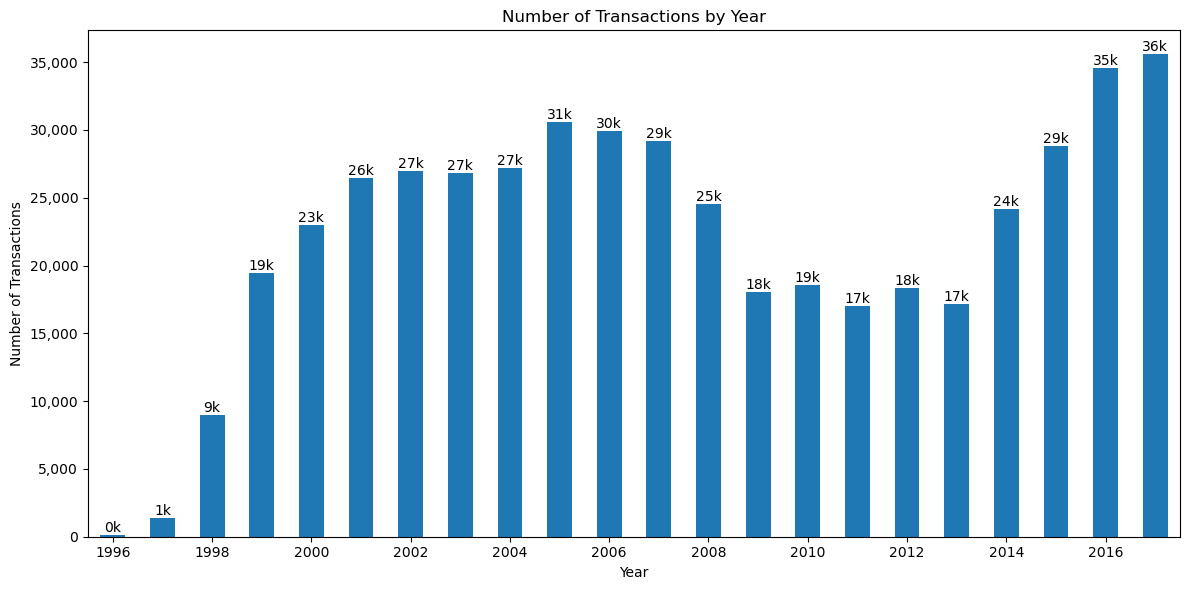

In [7]:
# Value counts of transactions by year
yearly_transactions = df['date_of_transaction'].dt.year.value_counts().sort_index()

# Visualize the yearly distribution
plt.figure(figsize=(12, 6))
ax = yearly_transactions.plot(kind='bar')
plt.title('Number of Transactions by Year')
plt.xlabel('Year')
plt.ylabel('Number of Transactions')
plt.xticks(range(len(yearly_transactions.index))[::2], yearly_transactions.index[::2], rotation=0)

# Add annotations on top of each bar
for i, v in enumerate(yearly_transactions):
    # Format the value to thousands (k) rounded to 1000 units
    formatted_value = f'{round(v/1000)}k'
    ax.text(i, v, formatted_value, 
            horizontalalignment='center',
            verticalalignment='bottom')

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.show()

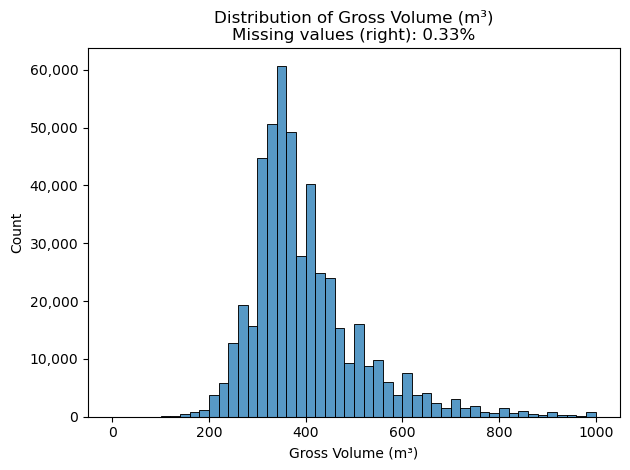

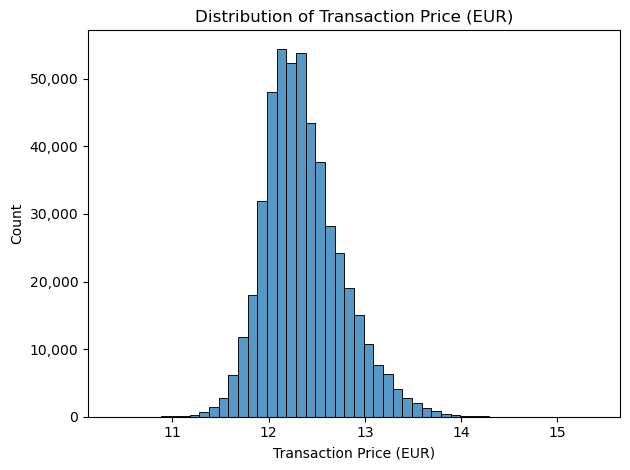

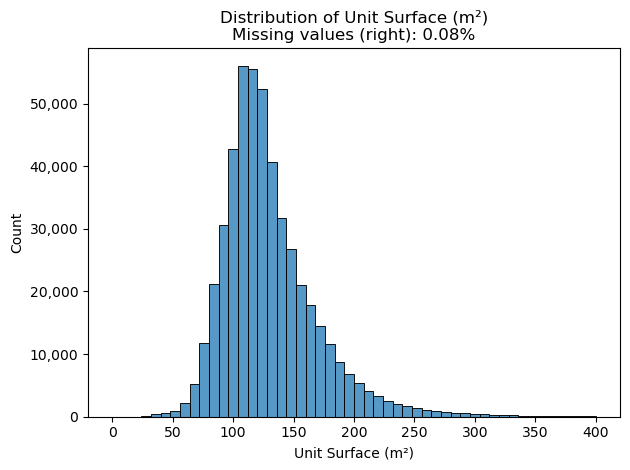

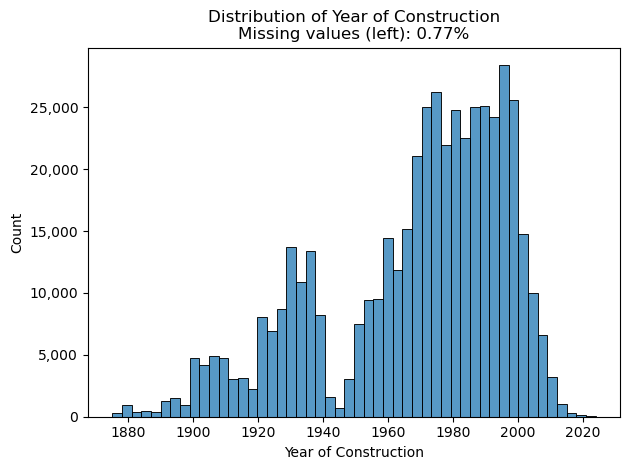

In [85]:
"""One‑by‑one histograms for key variables with clipping, annotations, and
thousands‑separated y‑axis ticks (uses seaborn histplot with 50 bins).
"""
from matplotlib.ticker import StrMethodFormatter

# Helper to format y‑axis with thousands separators
def _format_thousands(ax):
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Configuration for each variable: (column, x‑label, x‑lim tuple or None, side)
# side = 'left'  → compute % < xlim[0]
# side = 'right' → compute % > xlim[1]
# side = None    → no clipping / annotation
_vars = [
    ('gross_volume', 'Gross Volume (m³)', (0, 1000), 'right'),
    ('transaction_price', 'Transaction Price (EUR)', None, None),
    ('unit_surface', 'Unit Surface (m²)', (0, 400), 'right'),
    ('construction_yr', 'Year of Construction', (1875, None), 'left'),
]

for col, xlabel, xlim, side in _vars:
    series = df[col].dropna()
    if not len(series):
        continue  # skip empty columns

    # Determine limits
    if xlim is not None:
        lo, hi = xlim
        if hi is None:
            hi = series.max()
        xlim = (lo, hi)
    
    # Compute clipped‑value share
    if side is None:
        pct = 0.0
    elif side == 'right':
        pct = (series > xlim[1]).sum() / len(series) * 100
    elif side == 'left':
        pct = (series < xlim[0]).sum() / len(series) * 100
    else:
        raise ValueError("side must be 'left', 'right', or None")

    # Plot – always 50 bins within the shown range
    hist_kwargs = dict(bins=50)
    if xlim is not None:           # xlim already set to (lo, hi)
        hist_kwargs["binrange"] = xlim   # forces seaborn to place 50 bins between lo and hi

    sns.histplot(series, **hist_kwargs)

    _format_thousands(plt.gca())

    # Title with annotation
    if side is None:
        title = f"Distribution of {xlabel}"
    else:
        title = (
            f"Distribution of {xlabel}\n"
            f"Missing values ({side}): {pct:.2f}%"
        )
    plt.title(title)

    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

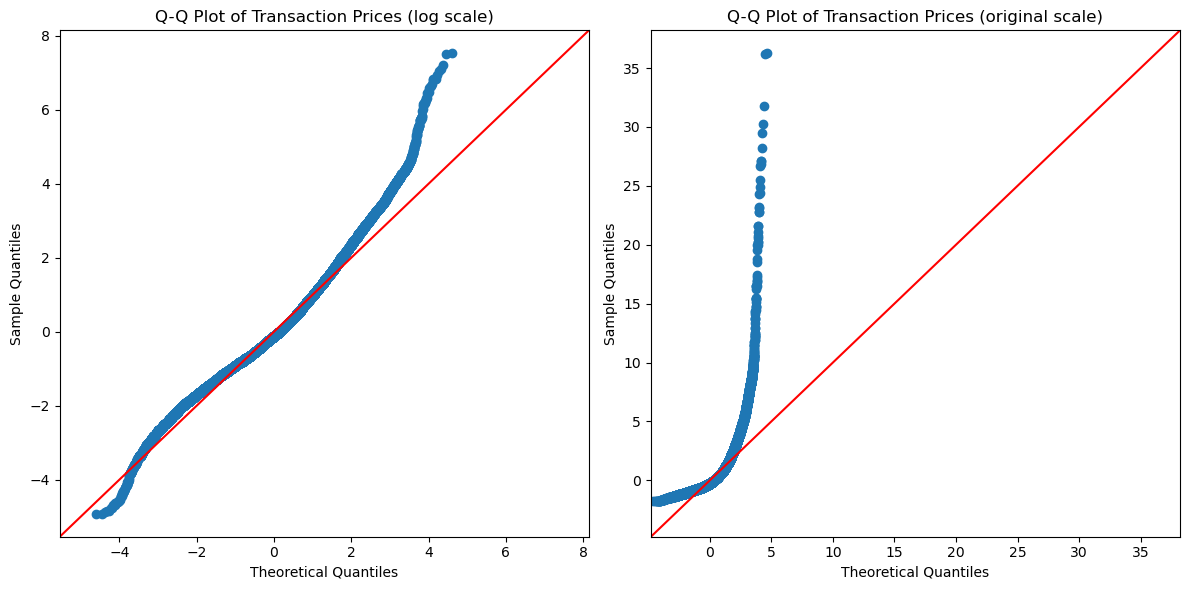

In [ ]:
# Create a new figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Create Q-Q plot for log scale
sm.graphics.qqplot(df['transaction_price'], line='45', fit=True, ax=ax1)
ax1.set_title('Q-Q Plot of Transaction Prices (log scale)')

# Create Q-Q plot for original scale
sm.graphics.qqplot(np.exp(df['transaction_price']), line='45', fit=True, ax=ax2)
#sm.graphics.qqplot(np.log1p(df['unit_surface']), line='45', fit=True, ax=ax2)
ax2.set_title('Q-Q Plot of Transaction Prices (original scale)')

plt.tight_layout()
plt.show()

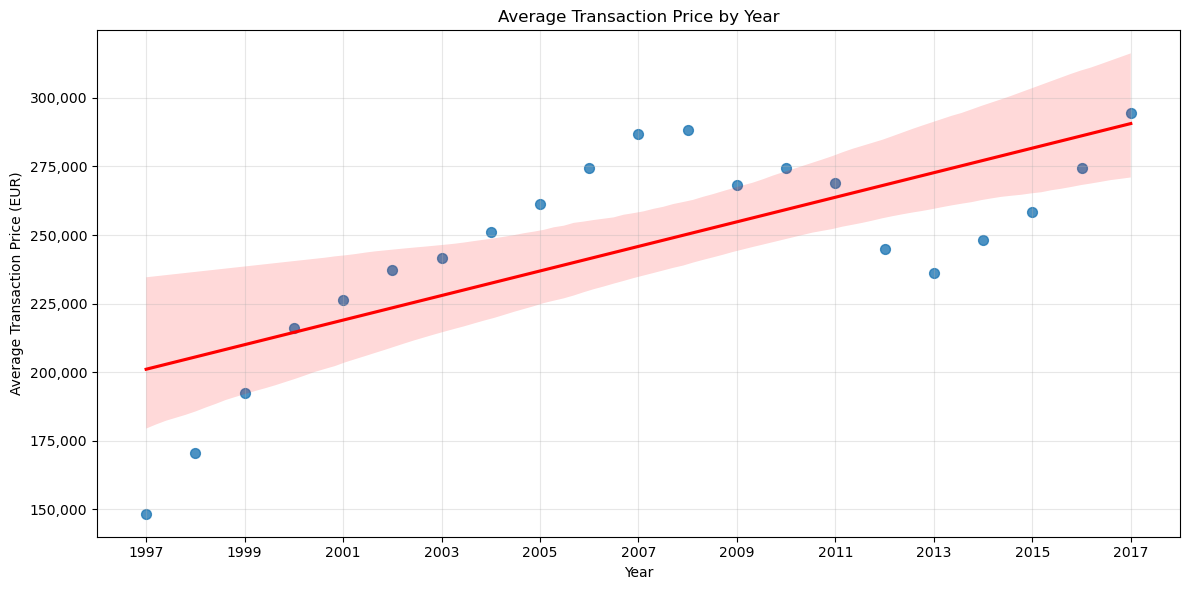

In [26]:
# Group by transaction year and calculate mean price
yearly_avg_price = df.groupby(df['date_of_transaction'].dt.year)['transaction_price'].apply(lambda x: np.exp(x).mean())

# Create the plot
plt.figure(figsize=(12, 6))
sns.regplot(x=yearly_avg_price.index, y=yearly_avg_price.values, 
            scatter_kws={'s': 50}, 
            line_kws={'color': 'red'})

plt.title('Average Transaction Price by Year')
plt.xticks(yearly_avg_price.index[::2])
plt.xlabel('Year')
plt.ylabel('Average Transaction Price (EUR)')

# Format y-axis to show thousands with comma
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

/var/folders/gm/q6vshmw56lv20sn76r21877r0000gn/T/ipykernel_97186/2099011920.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  period_avg_price = df.groupby('trans_period')['transaction_price'].apply(lambda x: np.exp(x).mean())


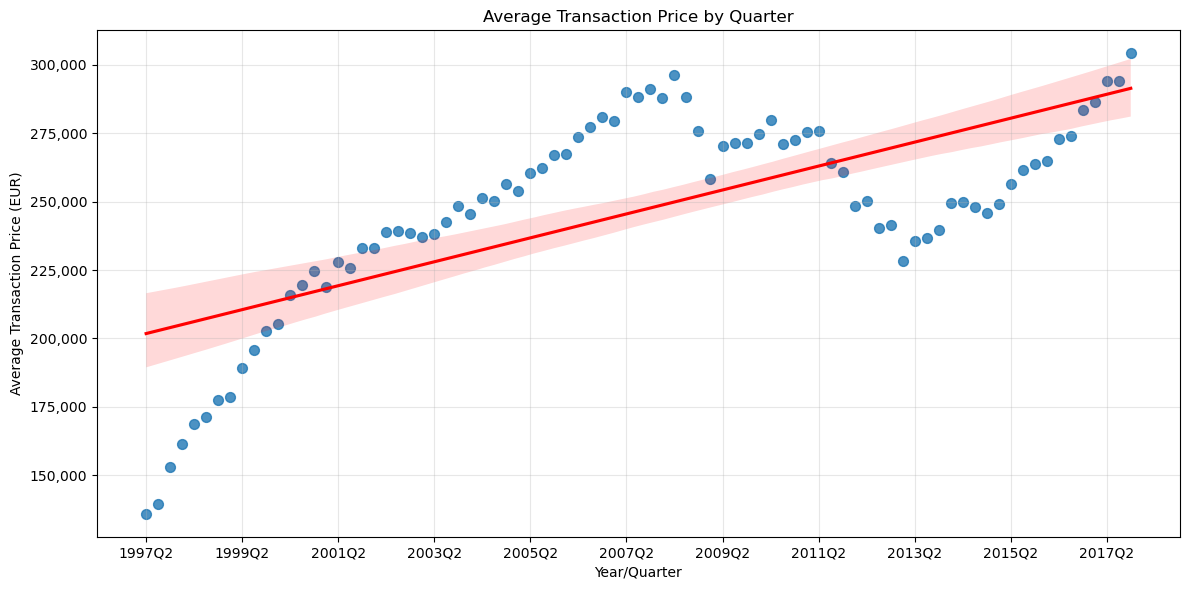

In [43]:
# Group by trans_period and calculate mean price
period_avg_price = df.groupby('trans_period')['transaction_price'].apply(lambda x: np.exp(x).mean())

# Create numeric x values for the regression
x_nums = np.arange(len(period_avg_price))

# Create the plot
plt.figure(figsize=(12, 6))
sns.regplot(x=x_nums, y=period_avg_price.values, 
            scatter_kws={'s': 50}, 
            line_kws={'color': 'red'})

plt.title('Average Transaction Price by Quarter')
plt.xticks(range(0, len(period_avg_price), 8), period_avg_price.index[::8])
plt.xlabel('Year/Quarter')
plt.ylabel('Average Transaction Price (EUR)')

# Format y-axis to show thousands with comma
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<Axes: xlabel='count', ylabel='monument'>

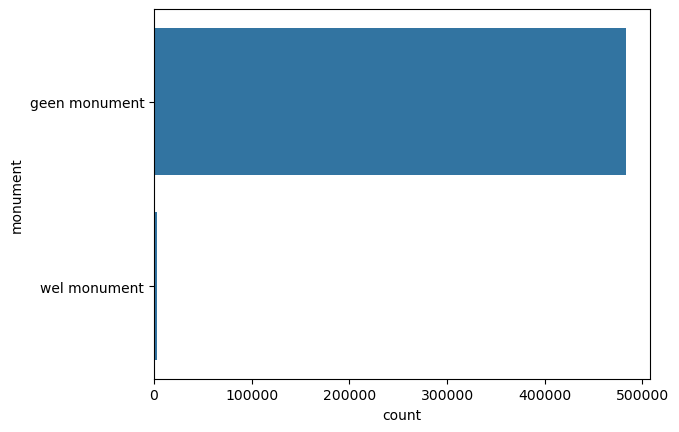

In [108]:
# Create plots to indentify whether there is categorical data that is quite uncommon that we could roll up? use_type, addition, property_class, property_type, qual_inside, qual_outside, shed, monument
#sns.countplot(df.property_type)
#sns.countplot(df.qual_inside)
sns.countplot(df.monument)

In [ ]:
df.addition.value_counts()
df.use_type.value_counts()

addition
       476012
A        6506
B        1877
C         714
D         335
        ...  
43A         1
43          1
42          1
410         1
W           1
Name: count, Length: 163, dtype: int64

In [54]:
df.corr(numeric_only=True).style.background_gradient()

,unit_id,property_id,construction_yr,unit_surface,housenumber,gross_volume,parcel_surface,rooms_nr,initial_list_price,last_list_price,transaction_price,duration,id,lon,lat,date_of_transaction_year,date_of_transaction_quarter,date_of_listing_year,date_of_listing_quarter,pc6_price_q1_prior,pc6_price_q4_prior,global_price_q1_prior,global_price_q4_prior,global_price_cum_prior
unit_id,1.000000,0.999093,0.008267,0.060761,-0.040065,0.065637,0.126179,0.019629,0.048411,0.043651,0.038537,0.060603,-0.056136,0.084981,-0.227853,0.033687,0.002046,0.027322,0.000802,0.033134,0.033288,0.026285,0.025830,0.032558
property_id,0.999093,1.000000,0.008549,0.060662,-0.040129,0.065459,0.126194,0.019579,0.048103,0.043345,0.038253,0.060530,-0.056265,0.085412,-0.228148,0.033639,0.002039,0.027282,0.000780,0.032836,0.033050,0.026308,0.025893,0.032577
construction_yr,0.008267,0.008549,1.000000,0.050514,0.037316,0.025734,-0.021414,0.038096,-0.067095,-0.062236,-0.052836,0.010636,-0.006923,0.044932,0.005749,0.056942,0.000581,0.056507,0.002653,-0.093037,-0.083355,0.045972,0.043268,0.052009
unit_surface,0.060761,0.060662,0.050514,1.000000,-0.004859,0.794192,0.567522,0.488180,0.624147,0.623579,0.614266,0.108132,-0.051531,0.056119,-0.031899,0.039222,0.003971,0.027526,-0.000678,0.100284,0.087318,0.025719,0.021096,0.030943
housenumber,-0.040065,-0.040129,0.037316,-0.004859,1.000000,-0.013628,-0.038994,-0.003754,-0.049912,-0.049031,-0.047710,-0.015755,0.244272,0.003254,-0.152578,-0.007108,-0.001545,-0.005455,0.000564,-0.018600,-0.017085,0.004513,0.004236,-0.000788
gross_volume,0.065637,0.065459,0.025734,0.794192,-0.013628,1.000000,0.534807,0.548331,0.680149,0.681208,0.674164,0.107051,-0.054187,0.033311,-0.059537,0.107072,0.012059,0.096806,0.003438,0.138504,0.119867,0.060898,0.048117,0.074539
parcel_surface,0.126179,0.126194,-0.021414,0.567522,-0.038994,0.534807,1.000000,0.265350,0.572968,0.564763,0.548079,0.149550,-0.080182,0.165700,-0.042916,0.048600,0.004390,0.032558,-0.005270,0.054361,0.050228,0.031457,0.030330,0.044394
rooms_nr,0.019629,0.019579,0.038096,0.488180,-0.003754,0.548331,0.265350,1.000000,0.417311,0.418991,0.416074,0.051202,-0.018521,0.030786,-0.017545,0.121307,0.010331,0.117795,0.000937,0.125129,0.120715,0.080325,0.080394,0.106561
initial_list_price,0.048411,0.048103,-0.067095,0.624147,-0.049912,0.680149,0.572968,0.417311,1.000000,0.990247,0.979386,0.156120,-0.081689,-0.210960,-0.039372,0.199305,0.018006,0.185312,0.001118,0.515096,0.502428,0.288823,0.288723,0.273856
last_list_price,0.043651,0.043345,-0.062236,0.623579,-0.049031,0.681208,0.564763,0.418991,0.990247,1.000000,0.991386,0.081571,-0.080245,-0.220432,-0.038300,0.184839,0.017475,0.179192,0.000979,0.520242,0.502945,0.288409,0.282436,0.259827


In [ ]:
# VIF table

/var/folders/gm/q6vshmw56lv20sn76r21877r0000gn/T/ipykernel_97186/3419492763.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
/var/folders/gm/q6vshmw56lv20sn76r21877r0000gn/T/ipykernel_97186/3419492763.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
/var/folders/gm/q6vshmw56lv20sn76r21877r0000gn/T/ipykernel_97186/3419492763.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')


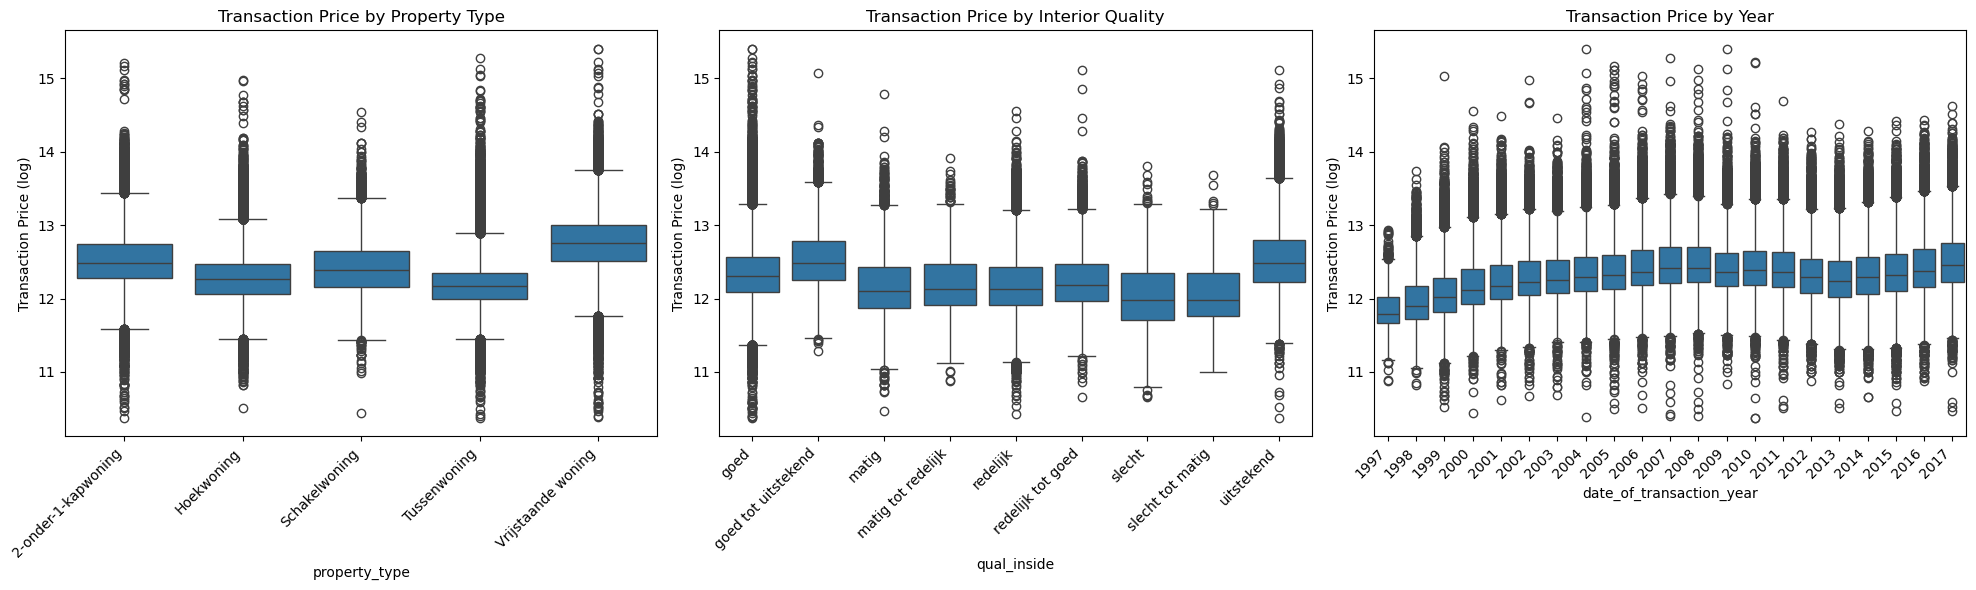

In [ ]:
# Create a figure with three subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot for property_type
sns.boxplot(data=df, x='property_type', y='transaction_price', ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_title('Transaction Price by Property Type')
ax1.set_ylabel('Transaction Price (log)')

# Boxplot for qual_inside
sns.boxplot(data=df, x='qual_inside', y='transaction_price', ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_title('Transaction Price by Interior Quality')
ax2.set_ylabel('Transaction Price (log)')

plt.tight_layout()
plt.show()


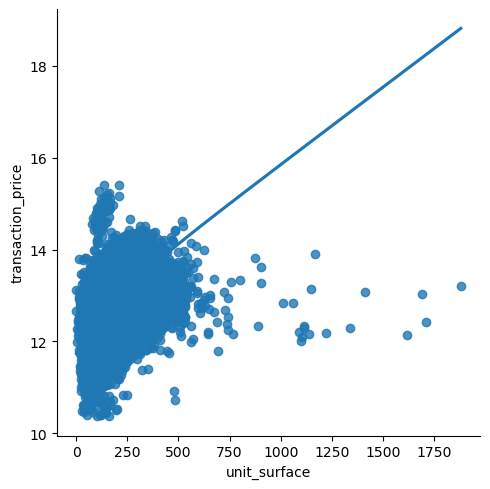

In [56]:
# Scatter with LOWESS: unit_surfaceÂ vsÂ price
sns.lmplot(x='unit_surface', y='transaction_price', data=df[df.unit_surface <= 2000], lowess=True)

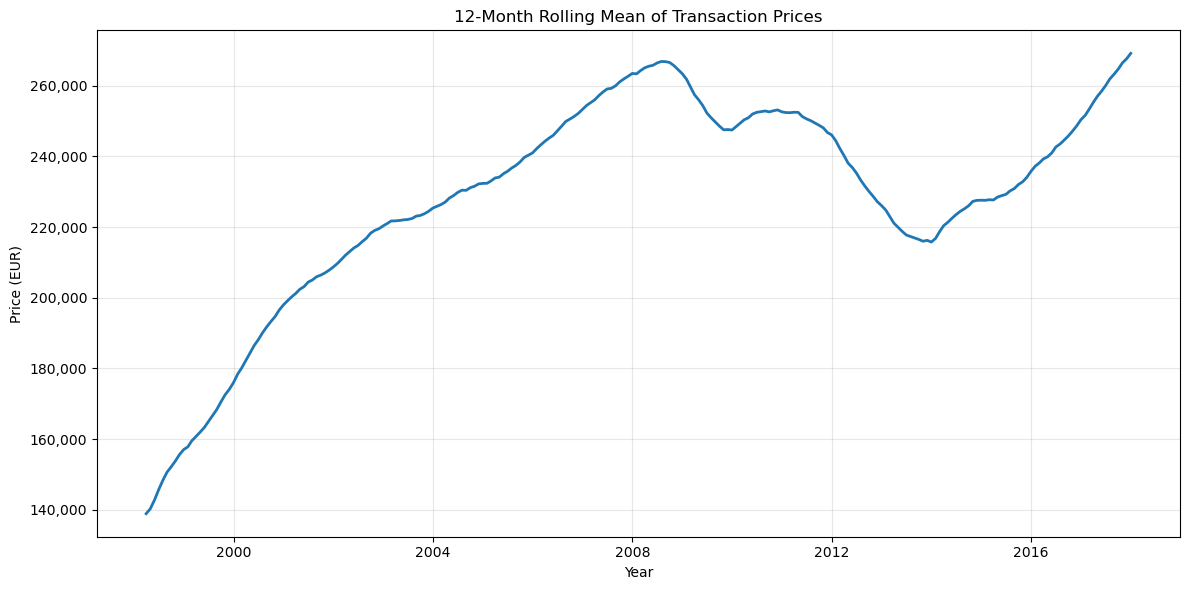

In [60]:
# Rolling mean transaction_price (12-month window)
# Calculate rolling mean of transaction price by month
monthly_avg = df.set_index('date_of_transaction').resample('ME')['transaction_price'].mean()
rolling_mean = monthly_avg.rolling(window=12).mean()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(rolling_mean.index, np.exp(rolling_mean.values), linewidth=2)

plt.title('12-Month Rolling Mean of Transaction Prices')
plt.xlabel('Year')
plt.ylabel('Price (EUR)')

# Format y-axis to show thousands with comma
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
def make_maps(
    df: pd.DataFrame,
    prov_path: str = "data/raw/provincies_2025.geojson",
    map_type: str = "static"  # "interactive", "static", or "both"
) -> folium.Map | tuple[folium.Map, folium.Map]:
    """
    Returns:
      - interactive_map: folium.Map with Gelderland highlighted & PC6 cluster
      - static_fig: matplotlib Figure with Gelderland + points colored by mean price
    """
    # 1. Load provinces
    provinces = gpd.read_file(prov_path)

    # 2. Compute one row per PC6 with mean price & centroid
    pc6_df = (
        df
        .groupby("pc6", as_index=False)
        .agg(
            lat=("lat", "first"),
            lon=("lon", "first"),
            price_mean=("transaction_price", "mean"),
        )
    )
    
    # convert mean log price to actual price
    pc6_df["price"] = np.expm1(pc6_df["price_mean"])
    # compute bounding box with 10% margin
    min_lat, max_lat = pc6_df["lat"].min(), pc6_df["lat"].max()
    min_lon, max_lon = pc6_df["lon"].min(), pc6_df["lon"].max()
    lat_margin = (max_lat - min_lat) * 0.1
    lon_margin = (max_lon - min_lon) * 0.1
    bounds = [
        [min_lat - lat_margin, min_lon - lon_margin],
        [max_lat + lat_margin, max_lon + lon_margin],
    ]

    # ——————————————————————————————————————————
    # Interactive Folium map
    interactive_map = None
    if map_type in ("interactive", "both"):
        m_interactive = folium.Map()
        m_interactive.fit_bounds(bounds)
        folium.GeoJson(
            provinces,
            style_function=lambda feat: {
                "fillColor": "#add8e6" if feat["properties"]["statnaam"] == "Gelderland" else "#ffffff",
                "color": "black",
                "weight": 1,
                "fillOpacity": 0.5,
            },
            name="Provinces"
        ).add_to(m_interactive)
        cluster = MarkerCluster().add_to(m_interactive)
        for _, row in pc6_df.iterrows():
            folium.CircleMarker(
                location=[row["lat"], row["lon"]],
                radius=2,
                color="darkblue",
                fill=True,
                fill_opacity=0.6,
                popup=f"PC6: {row['pc6']}<br>Mean price: €{row['price']:,.0f}"
            ).add_to(cluster)
        interactive_map = m_interactive

    # ——————————————————————————————————————————
    # Static matplotlib map
    static_map = None
    if map_type in ("static", "both"):
        m_static = folium.Map()
        m_static.fit_bounds(bounds)
        folium.GeoJson(
            provinces,
            style_function=lambda feat: {
                "fillColor": "#add8e6" if feat["properties"]["statnaam"] == "Gelderland" else "#ffffff",
                "color": "black",
                "weight": 1,
                "fillOpacity": 0.5,
            },
            name="Provinces"
        ).add_to(m_static)
        # add color scale for actual prices
        colormap = branca.colormap.LinearColormap(
            ["green", "red"], vmin=200000, vmax=750000, caption="Mean price (€)"
        )
        colormap.add_to(m_static)
        for _, row in pc6_df.iterrows():
            price = row["price"]
            color = colormap(price)
            folium.CircleMarker(
                location=[row["lat"], row["lon"]],
                radius=2,
                color=colormap(price),
                fill=True,
                fill_opacity=0.4,
                popup=f"PC6: {row['pc6']}<br>Mean price: €{price:,.0f}"
            ).add_to(m_static)
        static_map = m_static

    if map_type == "interactive":
        return interactive_map
    if map_type == "static":
        return static_map
    return interactive_map, static_map

In [ ]:
make_maps(df, map_type="static")